In [0]:
#Read the csv file from drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
print(tf.__version__)
from sklearn.model_selection import train_test_split

# tf.enbale_eager_execution() // uncomment this code if you are using tf1 


2.2.0-rc2


In [0]:


#Import the data frame from the Google spreadsheet

id = "1Ot5qeB4xzG6KITURE8Q3w3RhXMaeJaib"

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data.csv')  
df = pd.read_csv('data.csv')


In [4]:
df.columns

Index(['Unnamed: 0', 'label', 'text', 'label_none', 'label_soft', 'label_tech',
       'label_code'],
      dtype='object')

In [0]:
#split the train and the test
train_text, test_text, train_label, test_label = train_test_split(df['text'], 
                                                    df[['label_none','label_soft','label_tech']], 
                                                    test_size=0.33, 
                                                    random_state=8)

In [6]:
test_label

,label_none,label_soft,label_tech
4106,0,1,0
7935,0,1,0
7937,1,0,0
7456,1,0,0
6183,0,1,0
...,...,...,...
2340,0,1,0
4601,0,1,0
6556,0,1,0
3443,0,0,1


In [0]:
train_text = np.array(train_text)
test_text = np.array(test_text)
train_label = np.array(train_label)
test_label = np.array(test_label)

In [0]:
vocab_size = 850
embedding_dim = 16
max_length = 300
oov_tok = "<00V>" 

In [0]:
#Word Embedding

tokenizer  = Tokenizer(num_words = vocab_size ,oov_token=oov_tok )
tokenizer.fit_on_texts(train_text)
#Create a dictionary
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_text)
train_pad =pad_sequences(train_sequences,padding='post',truncating='post',maxlen=max_length)
test_sequences = tokenizer.texts_to_sequences(test_text)
test_pad =pad_sequences(test_sequences,padding='post',truncating='post',maxlen=max_length)


In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(24,activation='relu'),
                             tf.keras.layers.Dense(3,activation='softmax')
])

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 16)           13600     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 75        
Total params: 27,779
Trainable params: 27,779
Non-trainable params: 0
_________________________________________________________________


In [27]:
num_epochs = 30
history =model.fit(train_pad,
         train_label,
         epochs=num_epochs,
         validation_data =(test_pad,test_label))

Epoch 1/30
215/215 [==============================] - 42s 195ms/step - loss: 0.2852 - accuracy: 0.9145 - val_loss: 0.2419 - val_accuracy: 0.9223
Epoch 2/30
215/215 [==============================] - 41s 189ms/step - loss: 0.1744 - accuracy: 0.9457 - val_loss: 0.2103 - val_accuracy: 0.9347
Epoch 3/30
215/215 [==============================] - 41s 190ms/step - loss: 0.1476 - accuracy: 0.9547 - val_loss: 0.2214 - val_accuracy: 0.9320
Epoch 4/30
215/215 [==============================] - 41s 192ms/step - loss: 0.1313 - accuracy: 0.9570 - val_loss: 0.2057 - val_accuracy: 0.9382
Epoch 5/30
215/215 [==============================] - 41s 191ms/step - loss: 0.1207 - accuracy: 0.9585 - val_loss: 0.2224 - val_accuracy: 0.9329
Epoch 6/30
215/215 [==============================] - 41s 192ms/step - loss: 0.1120 - accuracy: 0.9640 - val_loss: 0.2202 - val_accuracy: 0.9317
Epoch 7/30
215/215 [==============================] - 41s 193ms/step - loss: 0.1047 - accuracy: 0.9662 - val_loss: 0.2220 - val_ac

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

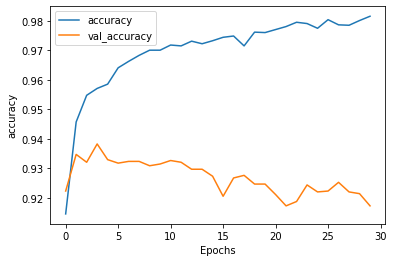

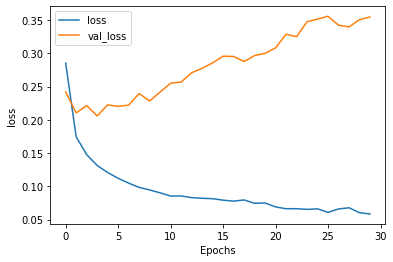

In [29]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history,"accuracy")
plot_graphs(history,"loss")

In [30]:
#Visualization and intepretation for the result 
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(850, 16)


In [0]:
reverse_word_index = dict([(value,key) for (key,value)in word_index.items()])
import io
out_v = io.open('vecs.tsv','w',encoding='utf-8')
out_m = io.open('meta.tsv','w',encoding='utf-8')

In [32]:
for word_num in range(1,vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word+"\n")
  out_v.write('\t'.join([str(x) for x in embeddings])+"\n")
out_v.close()
out_m.close

<function TextIOWrapper.close>

In [0]:
try :
  from google.colab import files 
except ImportError :
  pass
else :
  files.download('vecs.tsv')
  files.download('meta.tsv')
#import the file for tensorflow projector website

In [0]:
def decode_text(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [34]:
reverse_word_index[40]

'oder'

In [35]:
decode_text([40,300,201])

'oder 00 the'

In [0]:
def encode_text(text):
  sequences = tokenizer.texts_to_sequences(text)
  pad =pad_sequences(sequences,padding='post',truncating='post',maxlen=max_length)
  return pad

In [0]:
def predict():
  text_pred=[]
  pred= input ("Enter text  :")
  text_pred.append(pred) 
  if text_pred != "" :
    text_pred = encode_text(text_pred)
    prediction = model.predict(text_pred)
    print(prediction[0])
    if np.argmax(prediction[0]) == 2 :
      print( "text about the technical skills")
    elif np.argmax(prediction[0])== 1:
      print("text about the soft skills")
    else :
      print("text classify as none  ")

In [38]:
predict()

Enter text  :soziale Kompetenzen 
[5.3589628e-04 9.8617327e-01 1.3290872e-02]
text about the soft skills
